In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
import networkx as nx

import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud

In [2]:
df = pd.read_csv("train.csv", engine ='python')
df.head(5)

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [3]:
df['article'][2]

"A drunk driver who killed a young woman in a head-on crash while checking his mobile phone has been jailed for six years. Craig Eccleston-Todd, 27, was driving home from a night at a pub when he received a text message. As he was reading or replying to it, he veered across the road while driving round a bend and smashed into Rachel Titley’s car coming the other way. Craig Eccleston-Todd, 27 (left) was using his mobile phone when he crashed head-on into the car being driven by Rachel Titley, 28 (right). She died later from her injuries . The head-on crash took place in October 2013. Mr Eccleston-Todd's car was barely recognisable (pictured) Police said Eccleston-Todd had drunk at least three or four pints of beer before getting behind the wheel. He was found guilty of causing death by dangerous driving at Portsmouth Crown Court yesterday. Miss Titley, a 28-year-old solicitor’s clerk from Cowes, Isle of Wight, had also spent the evening with friends at a pub but had not drunk any alcoho

In [4]:
def read_article_text(article_id):
    article = df['article'][article_id].split(". ")
    #print("article",article)
    sentences = []
    #print("==========================================================================================================")
    for i in article:
        sentences.append(i.replace("[^a-zA-Z]", " ").split(" ")) #replacing all non characters with "space"
    #print("sentences",sentences)
    sentences.pop() 
    
    return sentences


In [5]:
print(read_article_text(2))

[['A', 'drunk', 'driver', 'who', 'killed', 'a', 'young', 'woman', 'in', 'a', 'head-on', 'crash', 'while', 'checking', 'his', 'mobile', 'phone', 'has', 'been', 'jailed', 'for', 'six', 'years'], ['Craig', 'Eccleston-Todd,', '27,', 'was', 'driving', 'home', 'from', 'a', 'night', 'at', 'a', 'pub', 'when', 'he', 'received', 'a', 'text', 'message'], ['As', 'he', 'was', 'reading', 'or', 'replying', 'to', 'it,', 'he', 'veered', 'across', 'the', 'road', 'while', 'driving', 'round', 'a', 'bend', 'and', 'smashed', 'into', 'Rachel', 'Titley’s', 'car', 'coming', 'the', 'other', 'way'], ['Craig', 'Eccleston-Todd,', '27', '(left)', 'was', 'using', 'his', 'mobile', 'phone', 'when', 'he', 'crashed', 'head-on', 'into', 'the', 'car', 'being', 'driven', 'by', 'Rachel', 'Titley,', '28', '(right)'], ['She', 'died', 'later', 'from', 'her', 'injuries', ''], ['The', 'head-on', 'crash', 'took', 'place', 'in', 'October', '2013'], ['Mr', "Eccleston-Todd's", 'car', 'was', 'barely', 'recognisable', '(pictured)', 'P

In [6]:
def create_similarity_matrix(sentences, stop_words):
    
    similarity_matrix = np.zeros((len(sentences), len(sentences)))
    print("length of sentences is |",len(sentences))
 
    for index1 in range(len(sentences)):
      
        for index2 in range(len(sentences)):
            if index1 == index2: 
                
                continue 
                
            similarity_matrix[index1][index2] = sentence_similarity(sentences[index1], sentences[index2], stop_words)
            
           
    return similarity_matrix


In [7]:
def sentence_similarity(sent1, sent2, stopwords=None):
    if stopwords is None:
        stopwords = []
 
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
 
    all_words = list(set(sent1 + sent2))
    
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
 
    for w in sent1:
        if w in stopwords:
            continue
        
        vector1[all_words.index(w)] += 1

    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1
        
        
    
    return (1 - cosine_distance(vector1, vector2))

In [8]:
def word_cloud_generate(file):
    summary = ""
    with open(file, encoding='cp1252') as f:
        summary = ''.join(f.readlines())
            
    wordcloud = WordCloud(width=1600, height=800).generate(summary)
    plt.figure( figsize=(16,8), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.savefig('wordcloud.png', facecolor='k', bbox_inches='tight')   

In [9]:
def text_summary(article_id, top_n=3):
    stop_words = stopwords.words('english')
    summarize_text = []

    sentences =  read_article_text(article_id)

    sentence_similarity_martix = create_similarity_matrix(sentences, stop_words)
    
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_martix)
    
    scores = nx.pagerank(sentence_similarity_graph)
   
    nx.draw(sentence_similarity_graph,with_labels=True)
    
    ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)    
   

    for i in range(top_n):
      summarize_text.append(" ".join(ranked_sentence[i][1]))

    print("Summarize Text: \n", ". ".join(summarize_text))
    
    with open('summary.txt', 'w') as f:
        for text in summarize_text:
            print(text, file=f)  
    word_cloud_generate('./summary.txt')

Enter the index of Article index ID for Summarization (0 to 5): 2
A drunk driver who killed a young woman in a head-on crash while checking his mobile phone has been jailed for six years. Craig Eccleston-Todd, 27, was driving home from a night at a pub when he received a text message. As he was reading or replying to it, he veered across the road while driving round a bend and smashed into Rachel Titley’s car coming the other way. Craig Eccleston-Todd, 27 (left) was using his mobile phone when he crashed head-on into the car being driven by Rachel Titley, 28 (right). She died later from her injuries . The head-on crash took place in October 2013. Mr Eccleston-Todd's car was barely recognisable (pictured) Police said Eccleston-Todd had drunk at least three or four pints of beer before getting behind the wheel. He was found guilty of causing death by dangerous driving at Portsmouth Crown Court yesterday. Miss Titley, a 28-year-old solicitor’s clerk from Cowes, Isle of Wight, had also spe

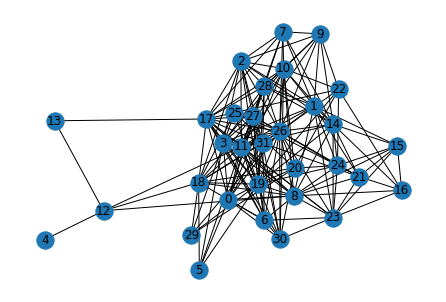

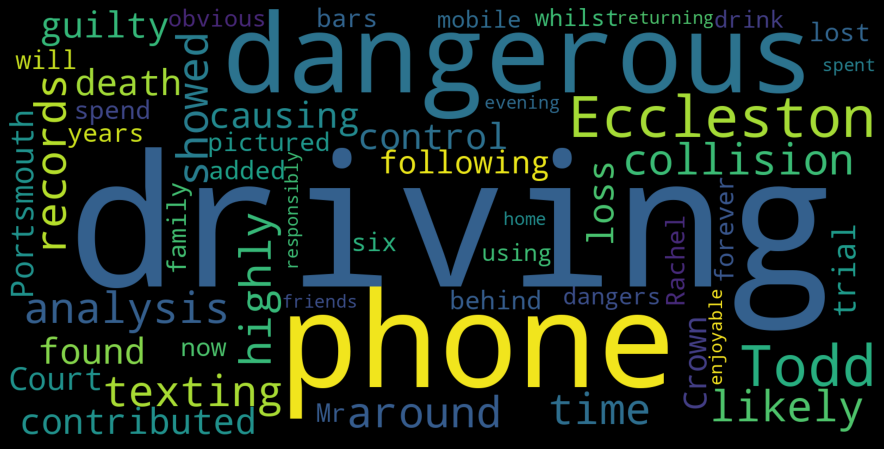

In [11]:
article_id = input("Enter the index of Article index ID for Summarization (0 to 5): ")
article_id=int(article_id)
print(df['article'][2])
text_summary(2)